In [ ]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn


# Training a Classifier

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

## What about data?

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


## Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [261]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



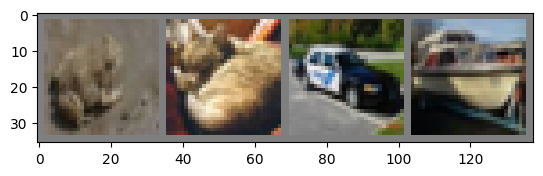

frog  cat   car   ship 


In [262]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [263]:
# 总共的小批量个数，每个小批量包含四个样本
len(dataiter)

12500

In [110]:
for i in dataiter:
    x = i
    print(x)
    break
    

[tensor([[[[ 1.0000,  0.8039,  0.5294,  ...,  0.4196,  0.6314,  0.9686],
          [ 0.7882,  0.5922,  0.2706,  ...,  0.0431,  0.4431,  0.7255],
          [ 0.5529,  0.3490,  0.0745,  ..., -0.1216,  0.1529,  0.3804],
          ...,
          [ 0.7961,  0.5843,  0.4275,  ...,  0.2078,  0.3882,  0.6000],
          [ 0.8667,  0.7255,  0.5686,  ...,  0.4353,  0.6235,  0.7804],
          [ 0.9922,  0.8510,  0.6863,  ...,  0.6471,  0.7725,  0.9451]],

         [[ 1.0000,  0.8431,  0.5922,  ...,  0.4902,  0.6784,  1.0000],
          [ 0.8275,  0.6706,  0.3804,  ...,  0.1608,  0.5294,  0.7804],
          [ 0.6157,  0.4588,  0.2392,  ...,  0.0588,  0.2863,  0.4588],
          ...,
          [ 0.8745,  0.7412,  0.6784,  ...,  0.5137,  0.6078,  0.7333],
          [ 0.9216,  0.8431,  0.7490,  ...,  0.6549,  0.7882,  0.8745],
          [ 1.0000,  0.9137,  0.7961,  ...,  0.7804,  0.8667,  0.9765]],

         [[ 1.0000,  0.7961,  0.5137,  ...,  0.4275,  0.6392,  0.9765],
          [ 0.7804,  0.5843, 

In [264]:
x[0].shape, x[1].shape

(torch.Size([4, 3, 32, 32]), torch.Size([4]))

In [265]:
x[1]

tensor([7, 7, 7, 5])

In [266]:
# images是四维张量，这也是图像数据的一般形式，表示(批量大小，通道数，高度，宽度)。
# 通道数为3代表了RGB三原色，高度宽度均为32代表了每个图像是由32*32个像素点构成的
images.shape, labels.shape

(torch.Size([4, 3, 32, 32]), torch.Size([4]))

In [267]:
images[0].shape

torch.Size([3, 32, 32])

In [268]:
# labels代表classes中对应索引的类别
labels

tensor([6, 3, 1, 8])

In [269]:
classes

('plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [184]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 输入通道为3，输出通道为6，
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # 最终的输出的形状：(样本数, 10)
        return x


net = Net()

#### 测试一下卷积核的形状

In [183]:
input = torch.randn(2, 3, 4, 5)
input

tensor([[[[ 0.6225, -0.8113, -1.8838, -0.2240,  0.2866],
          [-0.0669, -1.4303, -2.9979, -1.2393, -1.6159],
          [-1.2844, -0.4319,  0.9939, -0.2550,  0.1937],
          [-3.0341, -0.6222,  0.3282,  2.5938,  0.0217]],

         [[-1.0176,  1.6110, -0.2397, -0.9023,  1.4768],
          [-0.6748,  0.0756, -0.6852,  0.6152, -0.1683],
          [-0.2232, -0.7124, -0.5200, -1.3011, -0.7381],
          [ 0.6417, -0.2909, -0.4589, -0.6818, -1.8558]],

         [[ 0.4817, -0.6089, -1.0552,  1.6166, -0.7537],
          [-0.3851, -1.6183,  0.4431, -0.1010,  2.1800],
          [-0.0835,  1.1149,  0.4344,  0.9962, -1.9566],
          [ 1.6456,  0.0948,  0.0496, -0.6095, -0.6063]]],


        [[[ 0.2601,  1.8444, -1.4860,  2.1580,  0.0430],
          [ 0.5619, -0.7727,  1.4346,  0.5709,  1.8412],
          [-0.4810, -2.0775, -1.0071,  0.9915,  0.2114],
          [-0.7517, -1.1980, -2.1478, -0.0142,  0.1597]],

         [[-0.2679,  0.1812,  0.6679, -1.1643, -0.1946],
          [-0.2755,  

In [184]:
input.shape

torch.Size([2, 3, 4, 5])

[tutorial](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)

1. 对于四维张量的输入，in_channels代表输入的通道数，在此例中输入的通道数为3，则in_channel参数必须由输入的形状确定，否则会报错。即：我们需要保证 in_channels = input.shape[1]

2. out_channels代表输出的通道数，对于四维张量，核函数有几个矩阵组，就有几个输出通道，则输出通道数量可以指定

3. 如果输入样本的批量大小大于1，则对于每一个输入的样本，都会进行一次卷积。即输出的批量数 = 输入的批量数
output.shape[0] = input.shape[0]

4. 可以看出，Conv2d定义的核函数最多就是一个四维张量，形状为(输出通道数, 输入通道数，卷积核高度，卷积核跨度)

In [185]:
m = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 5), stride=1)
m

Conv2d(3, 4, kernel_size=(3, 5), stride=(1, 1))

In [186]:
for name, param in m.named_parameters():
    x = param.data
    break
    print(name, param.data)

卷积层的形状:(out_channels, in_channels, kernel_size[0], kernel_size[1])

In [187]:
x.shape

torch.Size([4, 3, 3, 5])

In [188]:
# (batch_size, channel, height, width)
output = m(input)
output.shape

torch.Size([2, 4, 2, 1])

In [141]:
output

tensor([[[[ 8.9423e-01,  1.5068e+00],
          [ 2.5219e-01, -1.1022e+00]],

         [[ 7.8779e-01, -9.8146e-01],
          [-1.8985e-01, -6.0783e-01]],

         [[ 6.5202e-02, -3.3441e-01],
          [-7.2188e-01,  1.1952e-02]],

         [[ 2.9757e-01, -1.4567e+00],
          [-4.0437e-01,  1.5513e-01]]],


        [[[-6.5894e-01,  6.8088e-01],
          [ 3.3791e-01, -4.1992e-01]],

         [[ 2.3165e-04,  3.3204e-02],
          [ 4.3622e-01, -9.0894e-01]],

         [[ 6.0523e-01, -9.0314e-01],
          [-1.1732e+00,  3.2243e-01]],

         [[ 7.8821e-01, -1.0278e-01],
          [ 6.2431e-01, -2.5323e-01]]]], grad_fn=<ConvolutionBackward0>)

In [142]:
x.shape

torch.Size([4, 3, 3, 3])

#### 看一看3D卷积核

input：<br>
batch_size = 2<br>
channel = 3<br>
length = 4<br>
width = 4<br>
height = 6

In [143]:
input = torch.randn(2, 3, 4, 4, 6)

In [144]:
m = nn.Conv3d(in_channels=3, out_channels=4, kernel_size=(3, 3, 2), stride=1)
m

Conv3d(3, 4, kernel_size=(3, 3, 2), stride=(1, 1, 1))

In [145]:
output = m(input)
output.shape

torch.Size([2, 4, 2, 2, 5])

思考一下为什么output的最后一个阶的维度是5：因为input最后一个阶是6，卷积核kernel的最后一个阶是2，将2在6长度上卷积，则结果是5维

In [146]:
output

tensor([[[[[ 0.2995, -0.2516,  0.0781, -0.5229, -0.6305],
           [ 0.5272,  1.0944,  0.6250, -0.3257,  0.5574]],

          [[-0.0381,  0.0107, -0.3247, -0.3197, -0.2873],
           [ 1.1302,  1.1678, -0.4066,  0.9155,  1.3612]]],


         [[[-0.6991, -0.3981, -0.8287,  0.3560, -0.7797],
           [ 1.0538,  1.2710,  1.0157, -0.4563, -1.0284]],

          [[-1.2038,  0.4122, -0.4734,  0.2056, -0.3488],
           [ 0.1822, -0.2392,  0.6679, -0.0028, -0.2663]]],


         [[[-0.3069, -0.2013,  0.6086, -0.8995, -0.4334],
           [-1.0282,  0.3515,  0.1661, -0.5898, -0.0159]],

          [[-0.0258, -0.8679,  0.3484, -1.2534,  0.3699],
           [ 0.9861, -1.8515,  0.9079, -0.5061,  0.0106]]],


         [[[-0.3252, -0.6444, -0.1278, -0.0578, -1.1351],
           [-0.1810,  0.5004, -0.5404,  1.1136, -0.0860]],

          [[ 0.0237,  0.0198, -0.7980, -0.8286,  0.1473],
           [ 0.1368, -0.8457, -0.4680, -0.1043, -0.4395]]]],



        [[[[ 1.4744, -0.5146,  0.6787,  0.6548

关于pytorch的默认填补

对于3D卷积核，如果输入是四阶（unbatched），则pytorch会在第一个维度填补batch_size = 1。此时输入中，input的第一个维度代表channel，则这里的cahnnel同理需要等于Conv3D的参数in_channels

对于3D卷积核，输入一定要大于等于4阶，否则会报错：RuntimeError: Expected 4D (unbatched) or 5D (batched) input to conv3d, but got input of size: [4, 4, 6]

In [147]:
input = torch.randn(3, 4, 4, 6)

In [148]:
m = nn.Conv3d(in_channels=3, out_channels=4, kernel_size=(3, 3, 2), stride=1)
m

Conv3d(3, 4, kernel_size=(3, 3, 2), stride=(1, 1, 1))

In [149]:
# 此时我们可以理解为我们只输入了一个样本进行，则输入和输出中batch所在的那个维度就没有必要存在了。
# 此时output.shape: (channel, length, width, height)
output = m(input)
output.shape

torch.Size([4, 2, 2, 5])

结论
1. 用3D卷积核，理论上应该输入五阶
 - 如果输入是四阶，那么默认输入数据是unbatched, 会自动填充batch_size 这个阶为1
 - 如果输入小于四阶，那么会报错
2. 用2D卷积核，同理理论上应该输入四阶
 - 如果输入是三阶，那么自动填充batch_size
 - 如果输入小于三阶，报错。

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [158]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [170]:
for iter_times, iter_element in enumerate([3, 2, 7], 0):
    print(iter_element, iter_times)

3 0
2 1
7 2


In [171]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        # 2000次的损失函数的累加，注意每次的损失都会减少，相当于对一个递减数列每隔2000项输出一个数列和
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.235
[1,  4000] loss: 1.917
[1,  6000] loss: 1.718
[1,  8000] loss: 1.615
[1, 10000] loss: 1.539
[1, 12000] loss: 1.471
[2,  2000] loss: 1.419
[2,  4000] loss: 1.387
[2,  6000] loss: 1.372
[2,  8000] loss: 1.328
[2, 10000] loss: 1.303
[2, 12000] loss: 1.312
Finished Training


#### 看一看细节

In [270]:
inputs.shape, labels

(torch.Size([4, 3, 32, 32]), tensor([6, 3, 1, 8]))

In [271]:
outputs = net(inputs)
outputs, outputs.shape

(tensor([[-2.1512,  0.1529,  1.6479,  1.5444,  1.5035,  0.9052,  6.7240, -2.6738,
          -4.6282, -1.3235],
         [-1.7226, -3.4159,  1.3129,  2.7902,  1.6486,  2.6387,  1.1697,  0.7477,
          -2.6952, -3.3751],
         [ 2.3464,  0.8334, -0.8974, -0.6976, -0.9966, -1.8850, -1.0086, -2.1002,
           2.9898,  2.0452],
         [ 0.0157,  1.2160,  0.1687, -0.1456, -0.2955, -0.8466, -0.7482, -0.7036,
          -0.0135,  0.4391]], grad_fn=<AddmmBackward0>),
 torch.Size([4, 10]))

In [272]:
outputs.sum(axis=1)

tensor([ 1.7013, -0.9010,  0.6294, -0.9134], grad_fn=<SumBackward1>)

Let's quickly save our trained model:



In [172]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



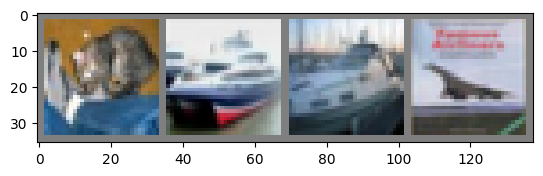

GroundTruth:  cat   ship  ship  plane


In [204]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



#### 这步将之前训练好的参数导入模型

In [205]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [206]:
outputs = net(images)
outputs

tensor([[-0.8840, -1.9322,  0.7545,  2.3560, -0.2670,  0.7243,  1.7412, -1.6958,
          0.4516, -2.0219],
        [ 4.3044,  5.7241, -2.2412, -2.3598, -3.0835, -4.0123, -4.4979, -3.6283,
          7.0589,  3.9774],
        [ 1.8818,  2.6752, -0.7233, -0.9703, -1.5518, -2.3249, -3.1088, -1.6351,
          3.2967,  2.4530],
        [ 4.4465, -0.6558,  0.4437, -0.9582,  0.0508, -2.8245, -2.4236, -1.9248,
          3.2848, -0.1935]], grad_fn=<AddmmBackward0>)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



[torch.max](https://pytorch.org/docs/stable/generated/torch.max.html#torch-max)

In [230]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


In [231]:
predicted

tensor([3, 8, 8, 0])

In [232]:
_

tensor([2.3560, 7.0589, 3.2967, 4.4465], grad_fn=<MaxBackward0>)

In [235]:
torch.max(outputs, 1)[0], torch.max(outputs, 1)[1]

(tensor([2.3560, 7.0589, 3.2967, 4.4465], grad_fn=<MaxBackward0>),
 tensor([3, 8, 8, 0]))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [195]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


In [241]:
(predicted == predicted).sum().item()

4

#### 将只包含一个元素的tensor转换为标量，无论维数多少都可以转换

In [256]:
predicted[0].item()

3

In [257]:
torch.tensor([[1]]).item()

1

That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Okay, so what next?

How do we run these neural networks on the GPU?

## Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Training on multiple GPUs
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

## Where do I go next?

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_




In [ ]:
del dataiter